In [1]:
import pandas as pd
import numpy  as np
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter("ignore")
hfont = {'fontname':'Monaco'}
hfont = {'fontsize':'24'}

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [2]:
#import the pickled dataframes you will be using for the experiments
experiment_df = pd.read_pickle('traceroute.pickle')
distance_df = pd.read_pickle('distance.pickle')

In [3]:
#Adding the source and destination coordinates to the experiment_df
# Create a dictionary with the source and destination coordinates
coord_mapping = {}
sources =  []
destinations = []
for index, row in distance_df.iterrows():
    source_dest_pair = (int(row['source_prb_id']), int(row['destination_prb_id']))
    sources.append(source_dest_pair[0])
    destinations.append(source_dest_pair[1])
    coord_mapping[source_dest_pair] = (row['source_longitude'], row['source_latitude'], row['destination_longitude'], row['destination_latitude'])

# Add the coordinates to the experiment_df
def add_coordinates(row):
    source_dest_pair = (int(row['prb_id']), int(row['dst_id']))
    if source_dest_pair in coord_mapping:
        coordinates = coord_mapping[source_dest_pair]
        row['source_longitude'], row['source_latitude'], row['destination_longitude'], row['destination_latitude'] = coordinates
    return row

# Apply the function to add coordinates to the final latency_df
latency_df = experiment_df.apply(add_coordinates, axis=1)

In [4]:
#extracting the date from the timestamp
latency_df['date'] = latency_df['new_time'].dt.date

In [5]:
#extracting the values for the cdf plot 
latency_df['last_rtt'] = latency_df.groupby(latency_df.index)['avg_rtt'].transform('last')

In [6]:
#pickling the dataframe with the distance and coordinates
latency_df.to_pickle('latency_noprobe.pickle')
analysis_df = latency_df.copy()

In [7]:
probe1 = analysis_df[analysis_df['prb_id'] == 33627]
probe2 = analysis_df[analysis_df['prb_id'] == 51265]
probe3 = analysis_df[analysis_df['prb_id'] == 55787]
probe4 = analysis_df[analysis_df['prb_id'] == 61357]
probe5 = analysis_df[analysis_df['prb_id'] == 15118]

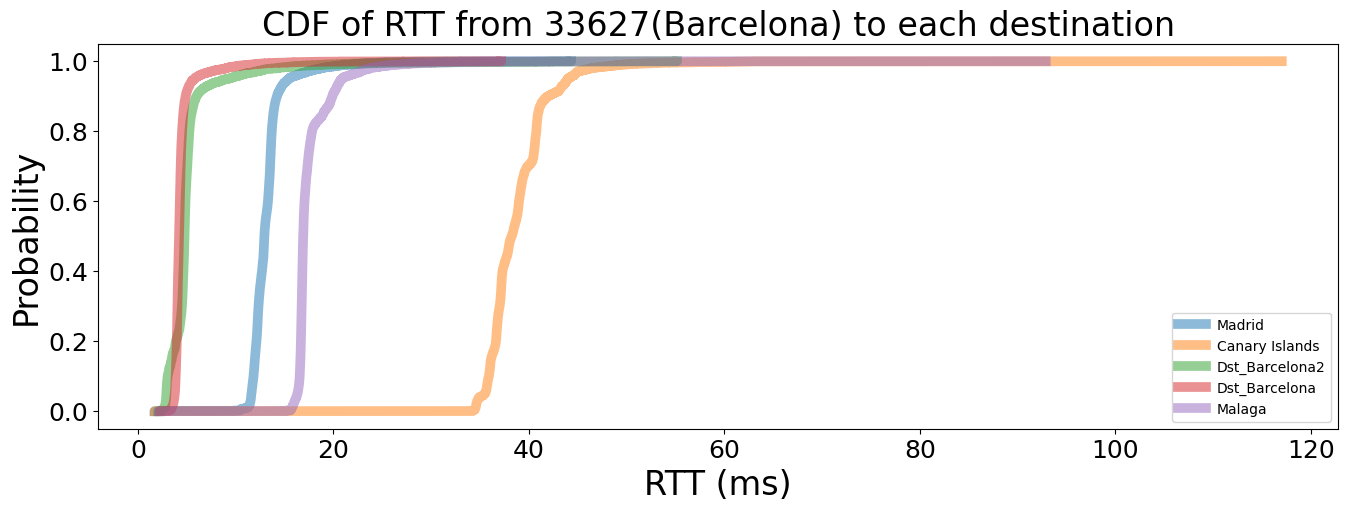

In [8]:
# plotting the cumulative distribution function from one probe to each of the destinations

#destination_probes = ['26072','30381','15632','1004200','14866']
destination_probes = latency_df['dst_names'].unique()

for probe in destination_probes:
    df_cdf = probe1[(probe1['dst_names'] == probe)]
    data = df_cdf['last_rtt'].sort_values()
    cumulative = [i / len(data) for i in range(len(data))]
    plt.plot(data, cumulative, label=probe, alpha=0.5, linewidth=7)

# Add labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('RTT (ms)',**hfont)
plt.ylabel('Probability', **hfont)
plt.title('CDF of RTT from 33627(Barcelona) to each destination',**hfont)

# Add legend
plt.legend(destination_probes)

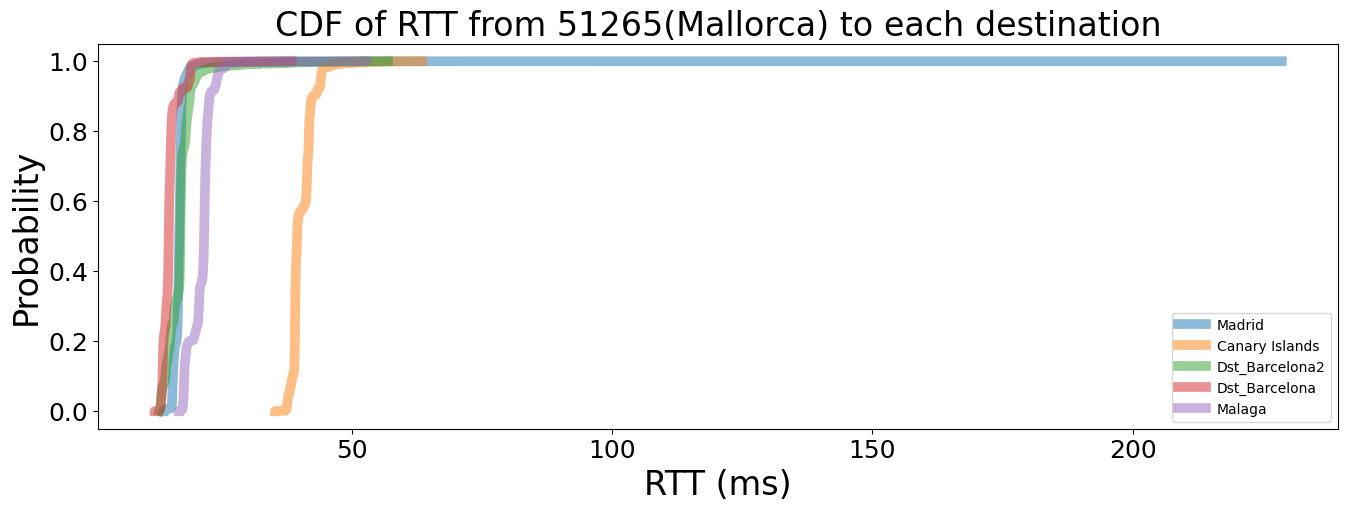

In [9]:
for probe in destination_probes:
    df_cdf = probe2[(probe2['dst_names'] == probe)]
    data = df_cdf['last_rtt'].sort_values()
    cumulative = [i / len(data) for i in range(len(data))]
    plt.plot(data, cumulative, label=probe, alpha=0.5, linewidth=7)

# Add labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('RTT (ms)',**hfont)
plt.ylabel('Probability', **hfont)
plt.title('CDF of RTT from 51265(Mallorca) to each destination',**hfont)

# Add legend
plt.legend(destination_probes)

In [44]:
def process_dataframe(df, threshold):
    for index, row in df.iterrows():
        if row['last_rtt'] > threshold:
            prev_index = index - 1
            next_index = index + 1

            prev_rtt = None
            while prev_index >= 0:
                if df.at[prev_index,'prb_id'] == row['prb_id'] and df.at[prev_index, 'dst_id'] == row['dst_id']:
                    if df.at[prev_index, 'last_rtt'] <= threshold:
                        prev_rtt = df.at[prev_index, 'last_rtt']
                        break
                prev_index -= 1

            next_rtt = None
            while next_index < len(df):
                if df.at[next_index, 'prb_id'] == row['prb_id'] and df.at[next_index, 'dst_id'] == row['dst_id']:
                    if df.at[next_index, 'last_rtt'] <= threshold:
                        next_rtt = df.at[next_index, 'last_rtt']
                        break
                next_index += 1

            # Calculate the mean of previous and next values if they exist
            if prev_rtt is not None and next_rtt is not None:
                mean_rtt = (prev_rtt + next_rtt) / 2
                if row['last_rtt'] > threshold:
                    df.at[index, 'last_rtt'] = mean_rtt
        
    return df

probe2 = analysis_df[analysis_df['prb_id'] ==51265].reset_index(drop=True)
probe2_modified = process_dataframe(probe2,60)

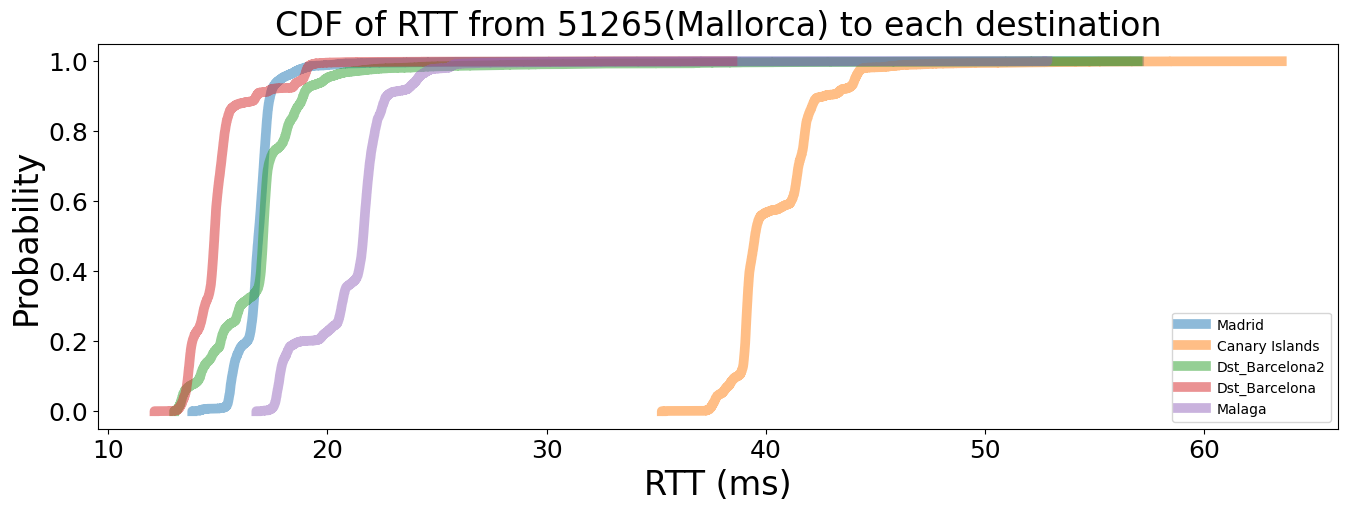

In [11]:
for probe in destination_probes:
    df_cdf = probe2_modified[(probe2_modified['dst_names'] == probe)]
    data = df_cdf['last_rtt'].sort_values()
    cumulative = [i / len(data) for i in range(len(data))]
    plt.plot(data, cumulative, label=probe, alpha=0.5, linewidth=7)

# Add labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('RTT (ms)',**hfont)
plt.ylabel('Probability', **hfont)
plt.title('CDF of RTT from 51265(Mallorca) to each destination',**hfont)

# Add legend
plt.legend(destination_probes)

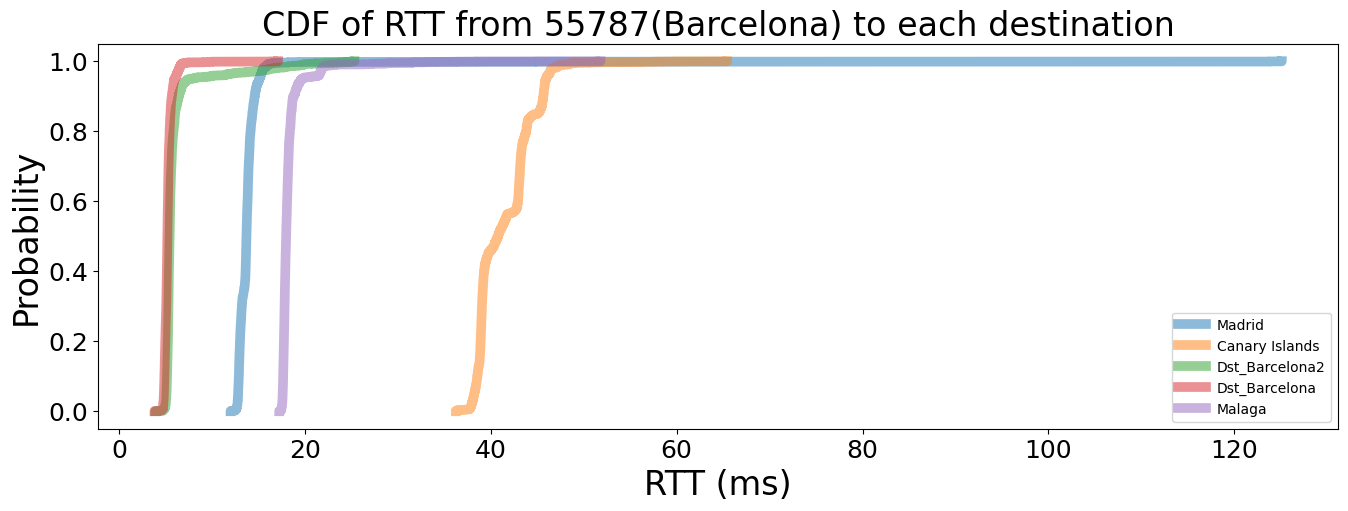

In [12]:
for probe in destination_probes:
    df_cdf = probe3[(probe3['dst_names'] == probe)]
    data = df_cdf['last_rtt'].sort_values()
    cumulative = [i / len(data) for i in range(len(data))]
    plt.plot(data, cumulative, label=probe, alpha=0.5, linewidth=7)

# Add labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('RTT (ms)',**hfont)
plt.ylabel('Probability', **hfont)
plt.title('CDF of RTT from 55787(Barcelona) to each destination',**hfont)

# Add legend
plt.legend(destination_probes)

In [13]:
def process_dataframe(df, threshold):
    for index, row in df.iterrows():
        if row['last_rtt'] > threshold:
            prev_index = index - 1
            next_index = index + 1

            prev_rtt = None
            while prev_index >= 0:
                if df.at[prev_index,'prb_id'] == row['prb_id'] and df.at[prev_index, 'dst_id'] == row['dst_id']:
                    if df.at[prev_index, 'last_rtt'] <= threshold:
                        prev_rtt = df.at[prev_index, 'last_rtt']
                        break
                prev_index -= 1

            next_rtt = None
            while next_index < len(df):
                if df.at[next_index, 'prb_id'] == row['prb_id'] and df.at[next_index, 'dst_id'] == row['dst_id']:
                    if df.at[next_index, 'last_rtt'] <= threshold:
                        next_rtt = df.at[next_index, 'last_rtt']
                        break
                next_index += 1

            # Calculate the mean of previous and next values if they exist
            if prev_rtt is not None and next_rtt is not None:
                mean_rtt = (prev_rtt + next_rtt) / 2
                if row['last_rtt'] > threshold:
                    df.at[index, 'last_rtt'] = mean_rtt
        
    return df

probe4 = analysis_df[analysis_df['prb_id'] == 61357].reset_index(drop=True)
probe4_modified = process_dataframe(probe4,250)

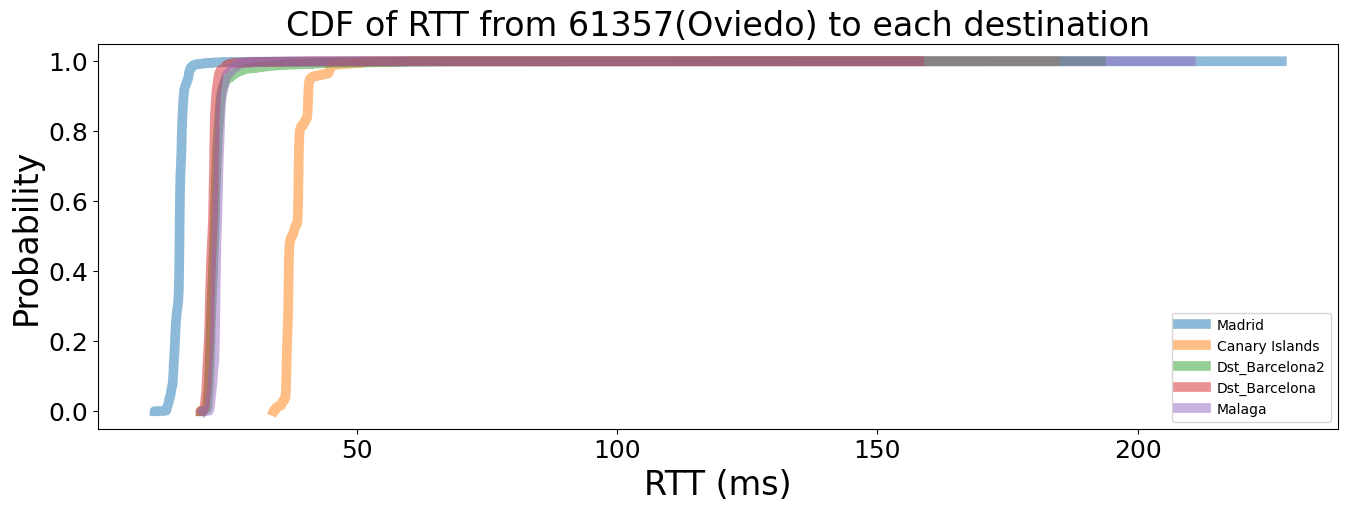

In [14]:
for probe in destination_probes:
    df_cdf = probe4_modified[(probe4_modified['dst_names'] == probe)]
    data = df_cdf['last_rtt'].sort_values()
    cumulative = [i / len(data) for i in range(len(data))]
    plt.plot(data, cumulative, label=probe, alpha=0.5, linewidth=7)

# Add labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('RTT (ms)',**hfont)
plt.ylabel('Probability', **hfont)
plt.title('CDF of RTT from 61357(Oviedo) to each destination',**hfont)

# Add legend
plt.legend(destination_probes)

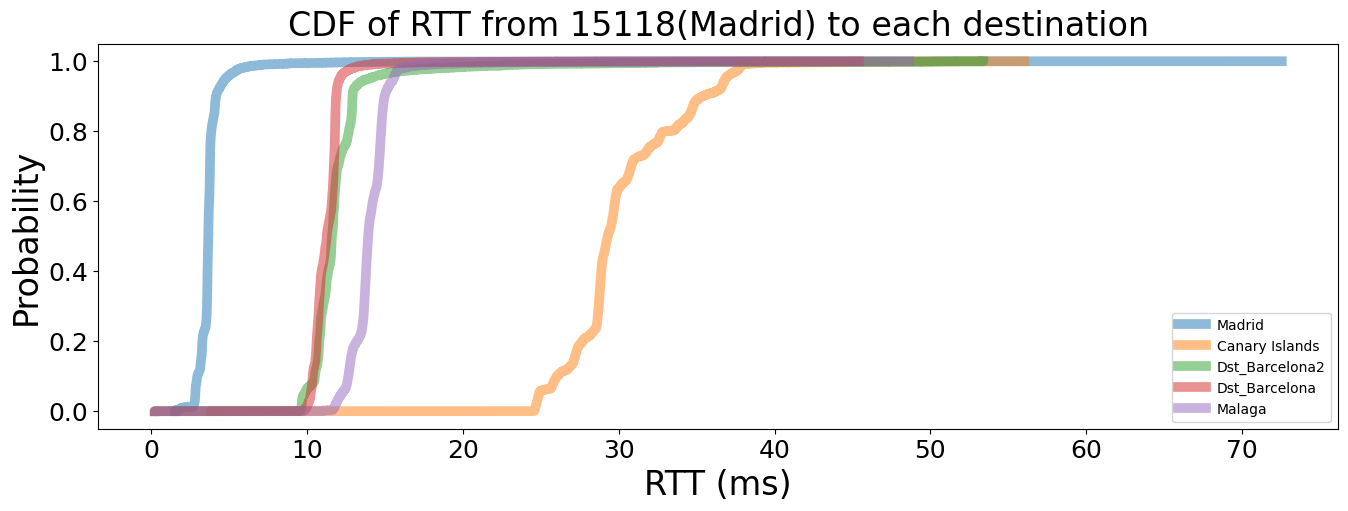

In [15]:
# Create the CDF plot with outlier replacement

probe5 = analysis_df[analysis_df['prb_id'] == 15118].reset_index(drop=True)
probe5_modified = process_dataframe(probe5, 200)

for probe in destination_probes:
    df_cdf = probe5_modified[(probe5_modified['dst_names'] == probe)]
    data = df_cdf['last_rtt'].sort_values()
    cumulative = [i / len(data) for i in range(len(data))]
    plt.plot(data, cumulative, label=probe, alpha=0.5, linewidth=7)

# Add labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('RTT (ms)',**hfont)
plt.ylabel('Probability', **hfont)
plt.title('CDF of RTT from 15118(Madrid) to each destination',**hfont)

# Add legend
plt.legend(destination_probes)

In [16]:
#plotting the mean latency per day 
plot_df = latency_df.copy()
plot_df['last_rtt'] = plot_df.groupby(plot_df.index)['avg_rtt'].transform('last')

In [17]:
plot_df = plot_df.groupby(['date','prb_id','dst_id'], as_index=False).agg({col: 'first' if col != 'last_rtt' else 'mean' for col in plot_df.columns})

In [18]:
import seaborn as sns 


def plot_mean(df,src,dst):
    #filter the particular source and destination
    df = df[(df['prb_id'] == src) & (df['dst_id'] == dst)]

    #get the source and destination labels 
    src = df['prb_id'].iloc[0]
    dst = df['dst_id'].iloc[0]
    
    #plot settings 
    #set the limits for the y axis
    min_y = 0 
    max_y = 60
    plt.ylim(min_y, max_y)
    
    #set the line color
    plt.plot(df['date'], df['last_rtt'], label='Daily Mean',color='darkorange')
    
    #settings for the x axis 
  
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.xlabel('Date', **hfont)
    
    #settings for the y axis
    plt.ylabel('avg_rtt(ms)', **hfont)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    #general setting for the figure
    plt.title(f'Daily Mean for {src} and {dst}', **hfont)
    plt.legend()
    plt.show()

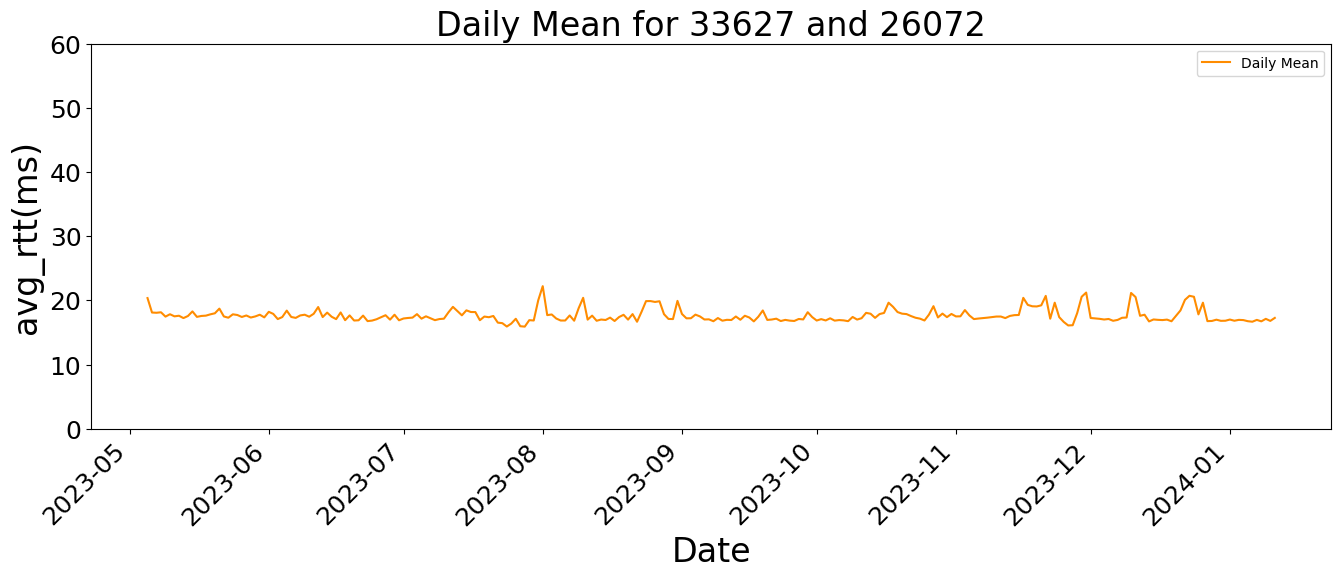

In [19]:
plot_mean(plot_df, sources[0], str(destinations[0]))

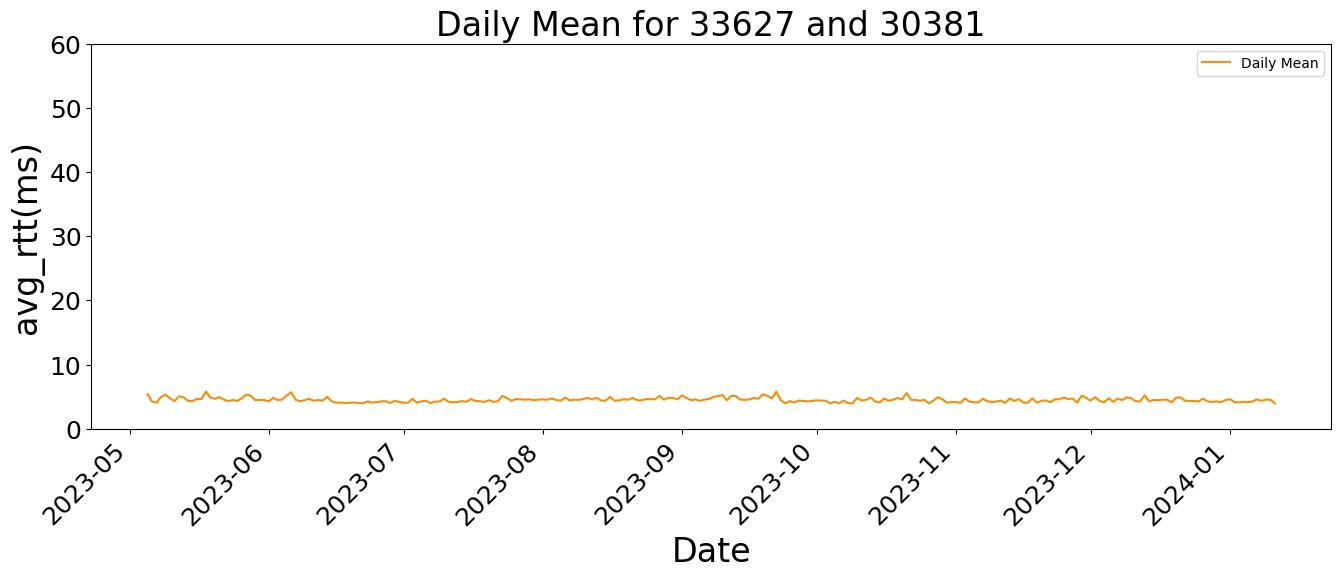

In [20]:
plot_mean(plot_df, sources[1], str(destinations[1]))

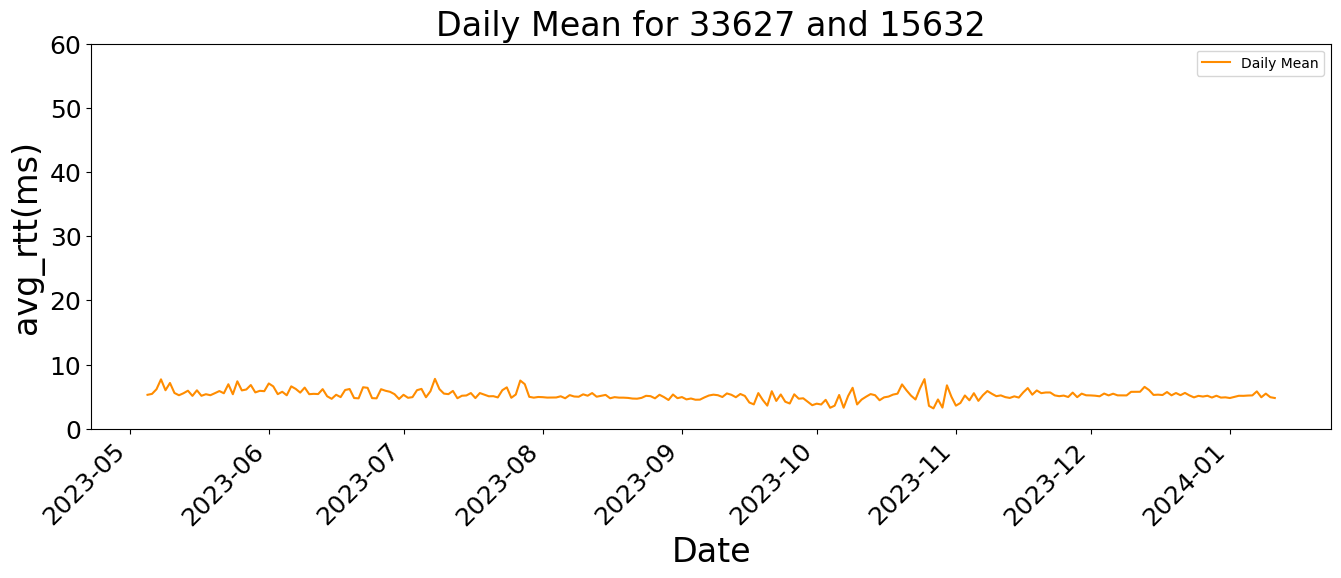

In [21]:
plot_mean(plot_df, sources[2], str(destinations[2]))

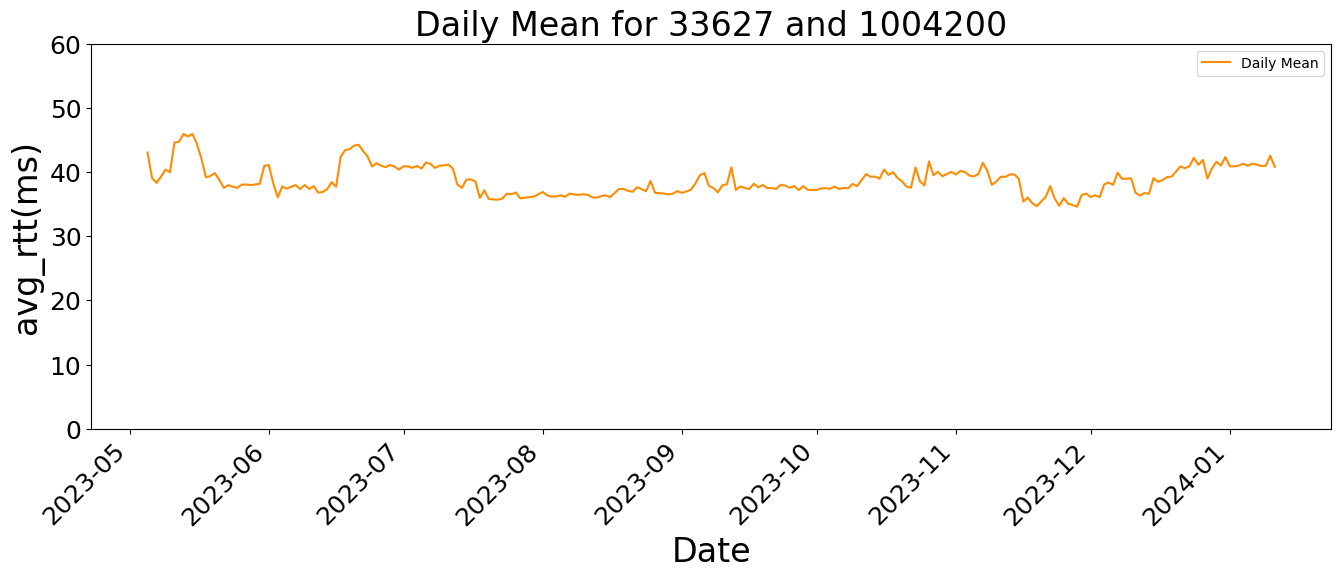

In [22]:
plot_mean(plot_df, sources[3], str(destinations[3]))

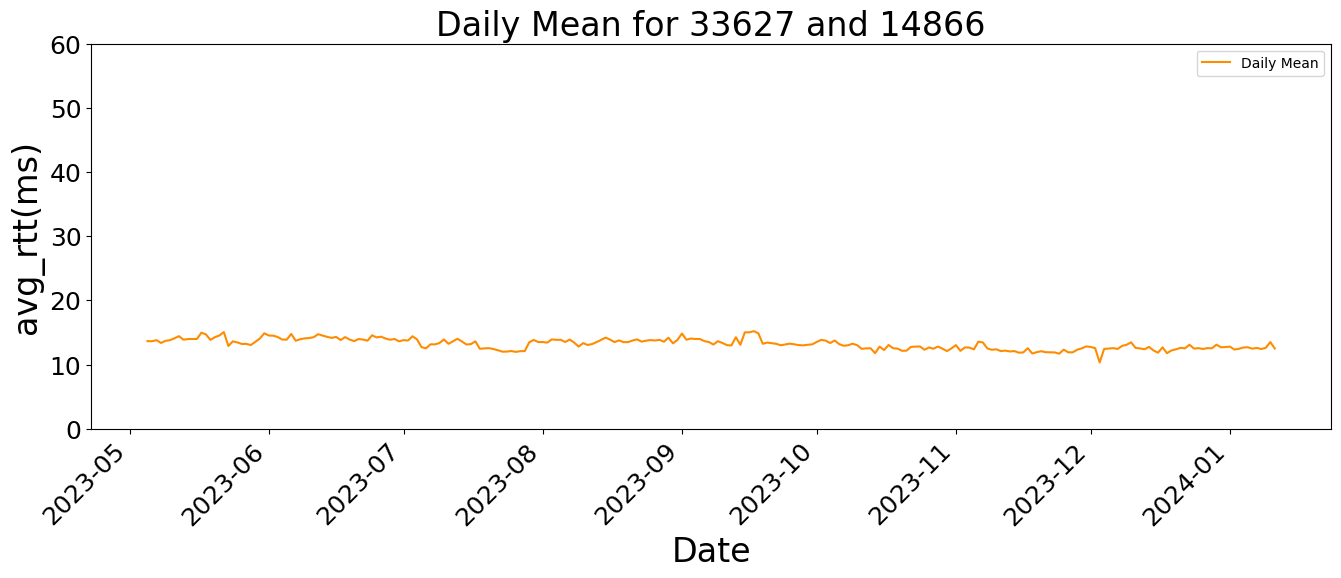

In [23]:
plot_mean(plot_df, sources[4], str(destinations[4]))

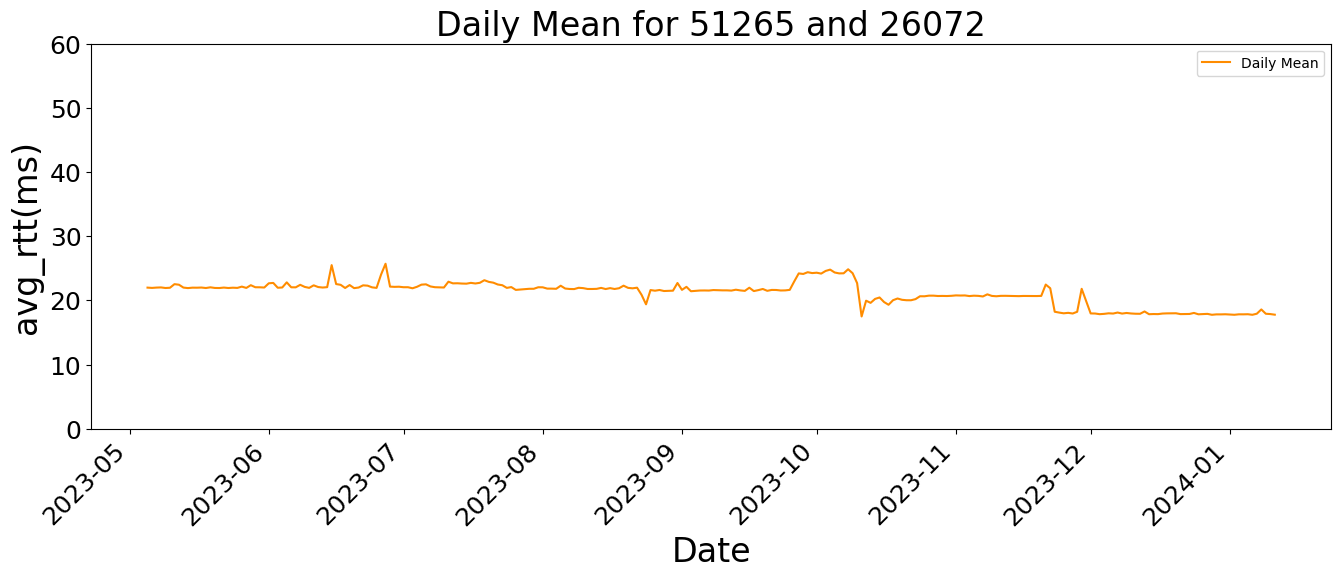

In [24]:
plot_mean(plot_df, sources[5], str(destinations[5]))

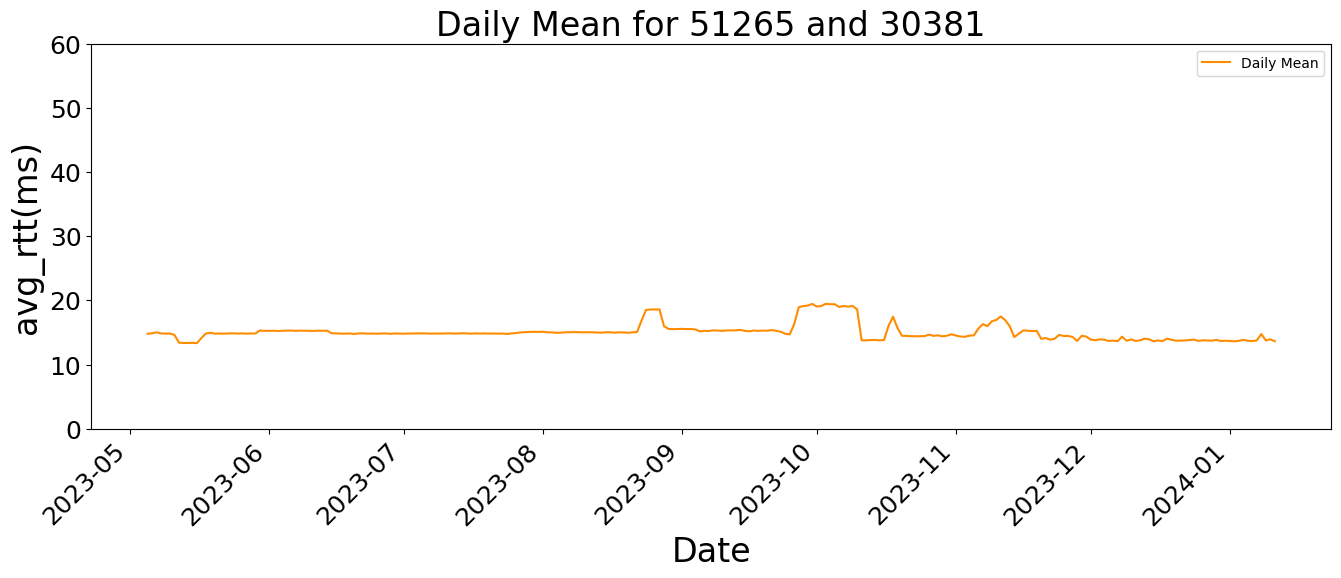

In [25]:
plot_mean(plot_df, sources[6], str(destinations[6]))

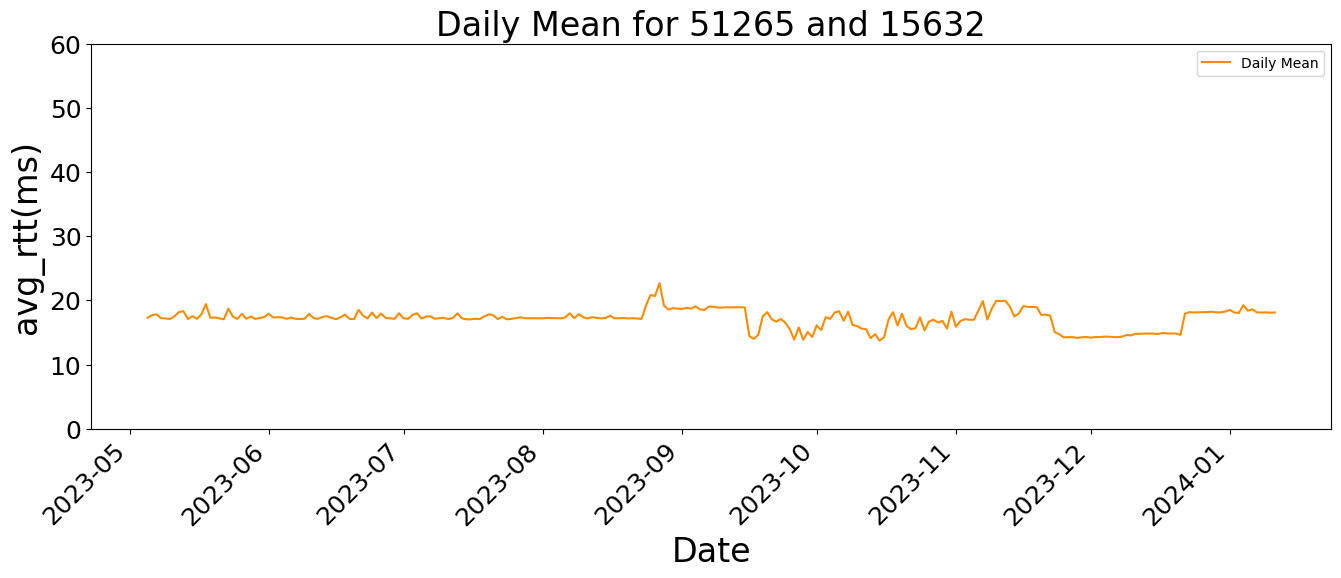

In [26]:
plot_mean(plot_df, sources[7], str(destinations[7]))

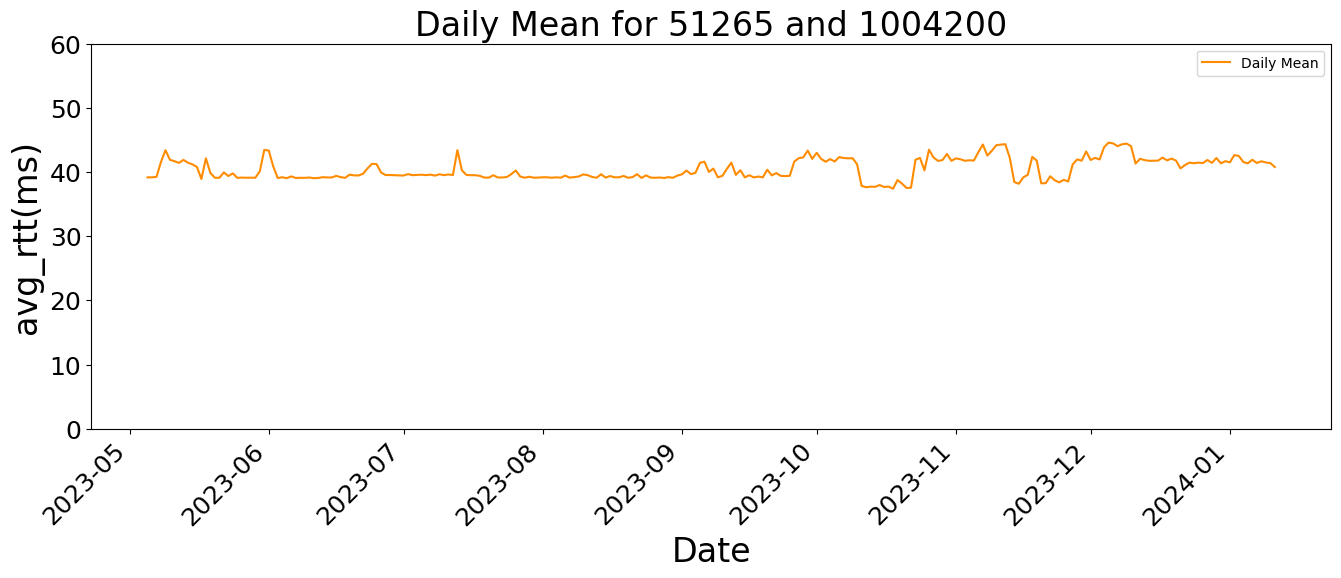

In [27]:
plot_mean(plot_df, sources[8], str(destinations[8]))

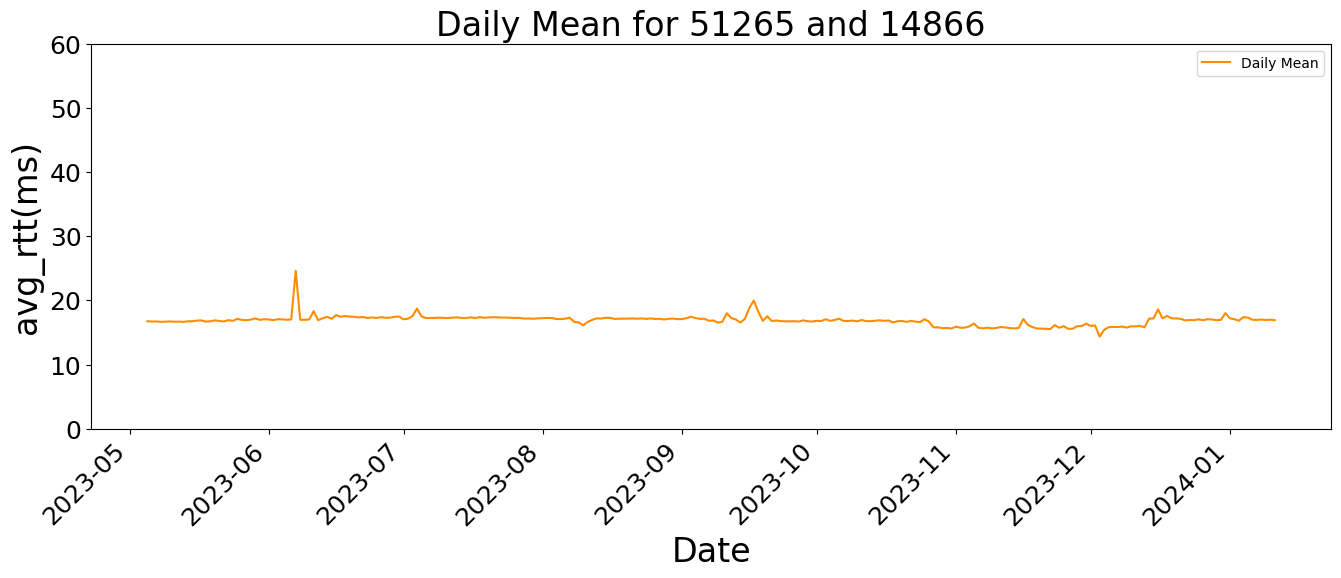

In [28]:
plot_mean(plot_df, sources[9], str(destinations[9]))

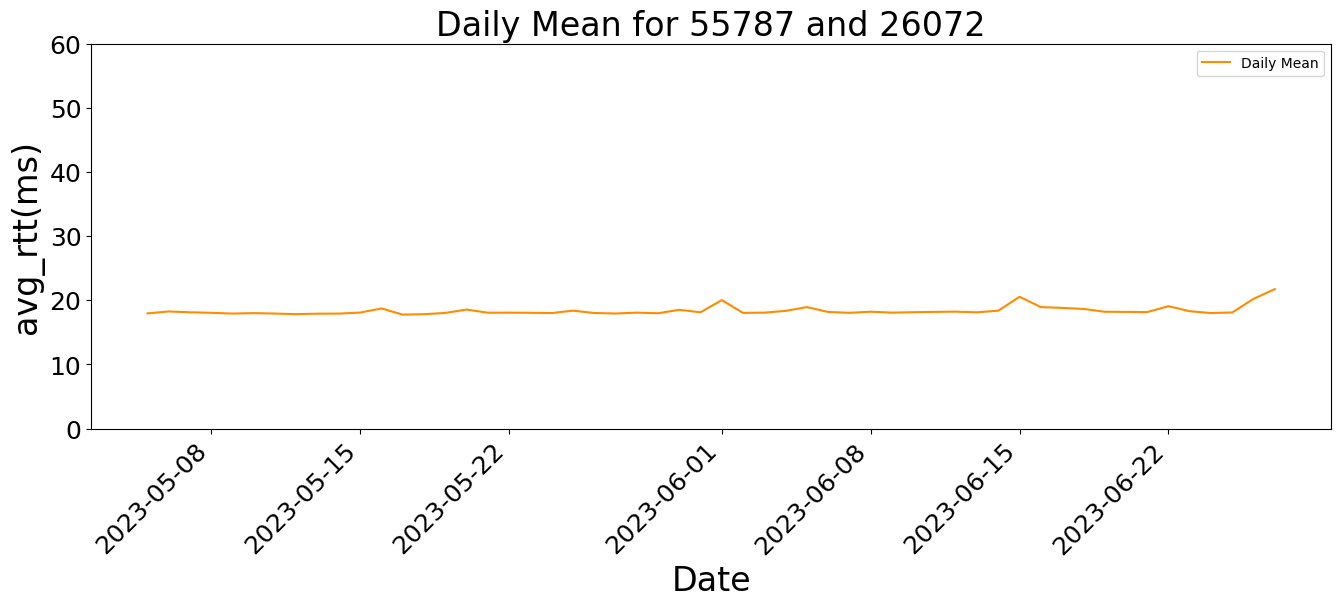

In [29]:
plot_mean(plot_df, sources[10], str(destinations[10]))

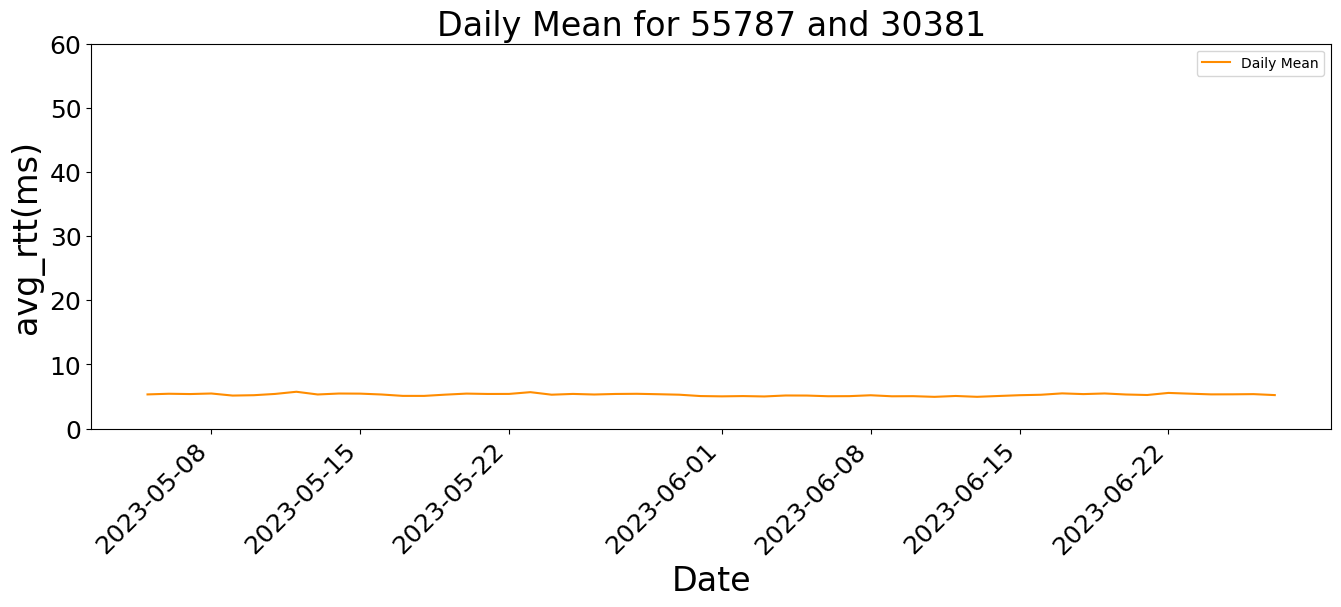

In [30]:
plot_mean(plot_df, sources[11], str(destinations[11]))

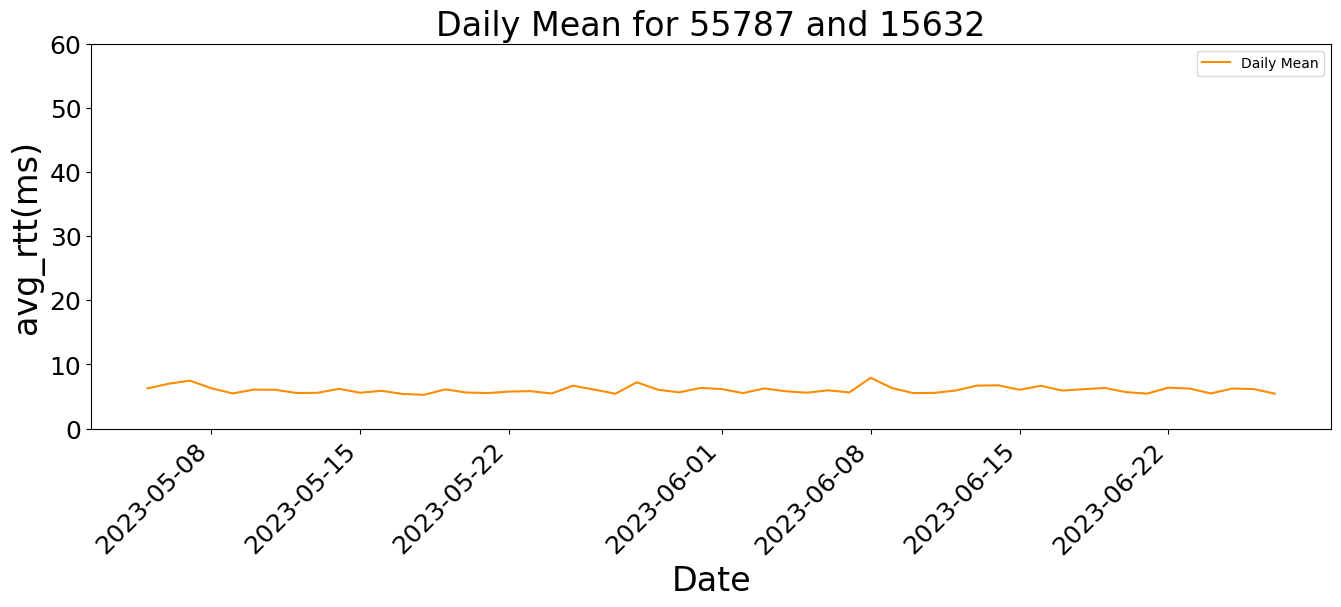

In [31]:
plot_mean(plot_df, sources[12], str(destinations[12]))

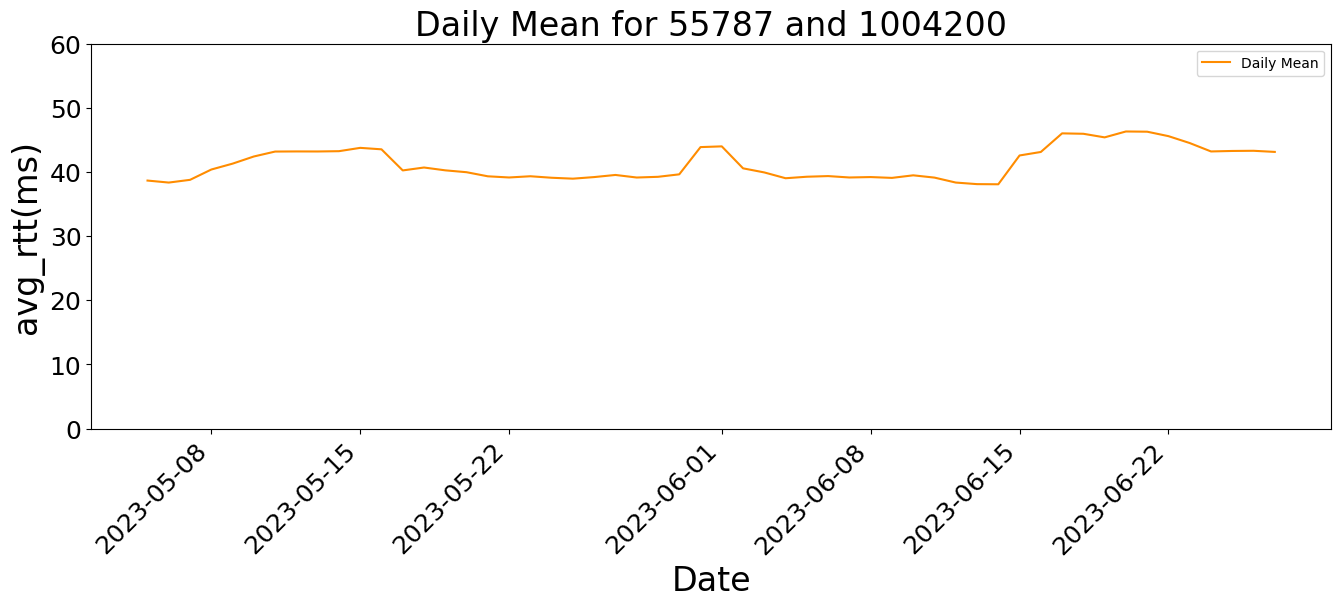

In [32]:
plot_mean(plot_df, sources[13], str(destinations[13]))

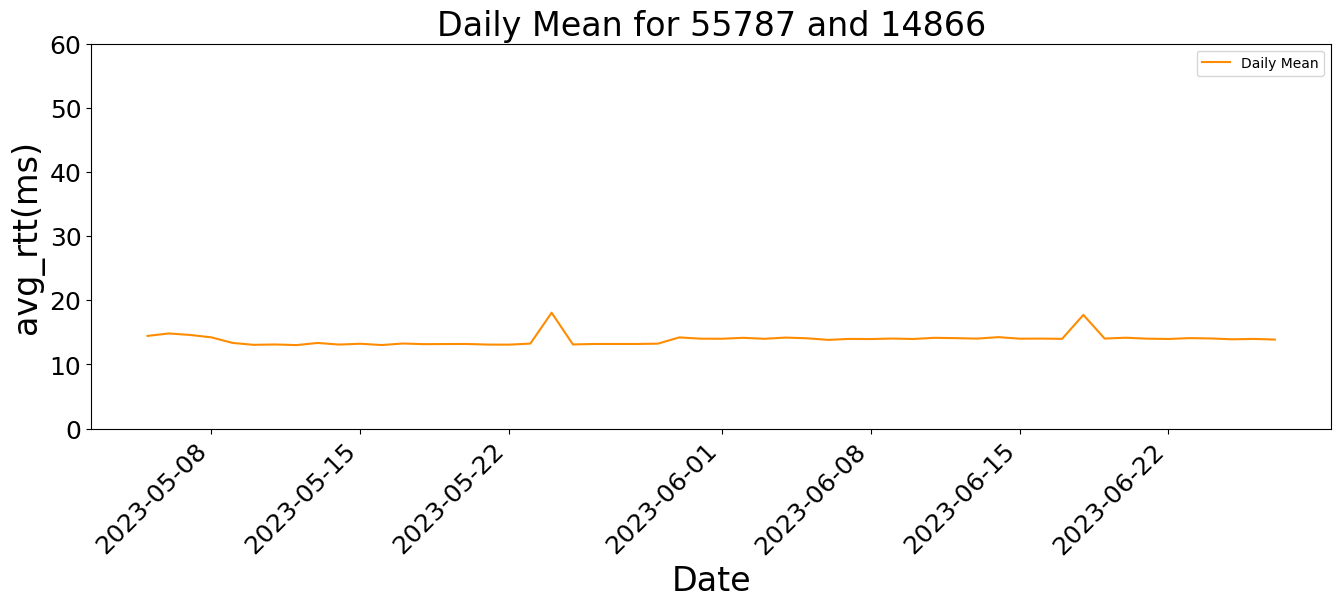

In [33]:
plot_mean(plot_df, sources[14], str(destinations[14]))

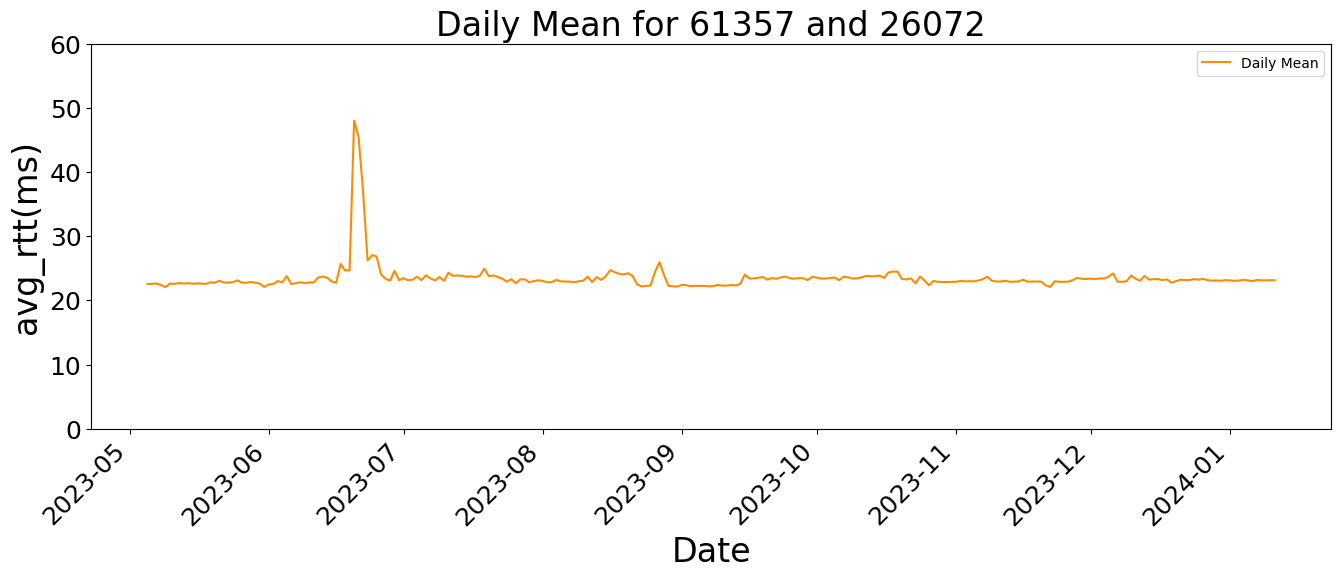

In [34]:
plot_mean(plot_df, sources[15], str(destinations[15]))

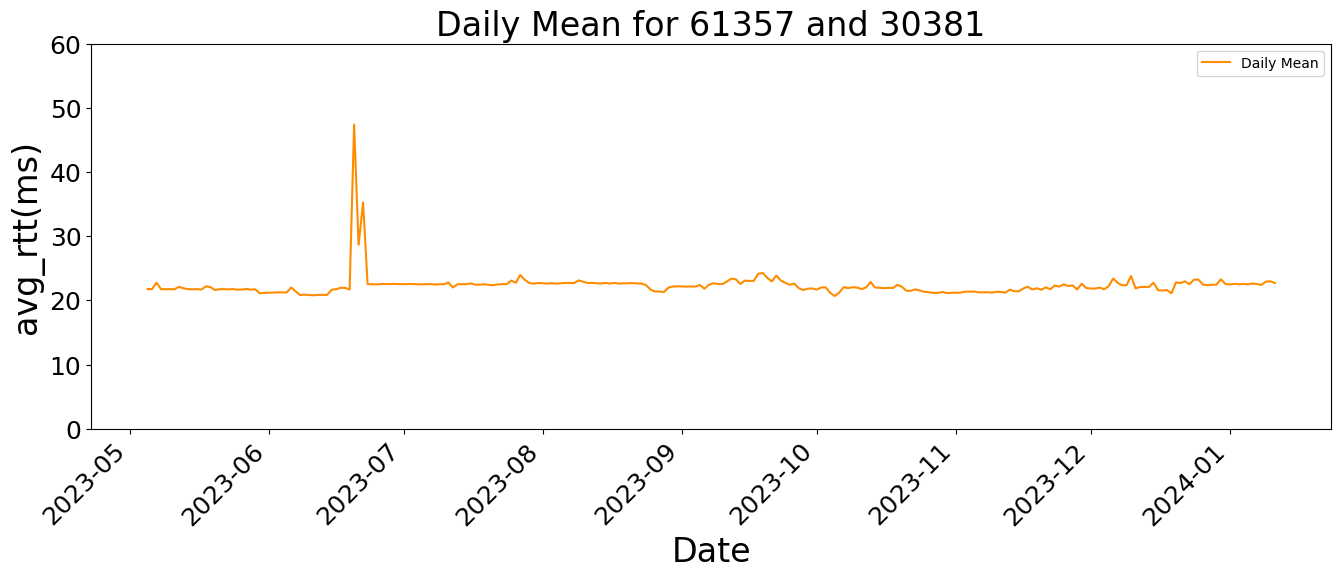

In [35]:
plot_mean(plot_df, sources[16], str(destinations[16]))

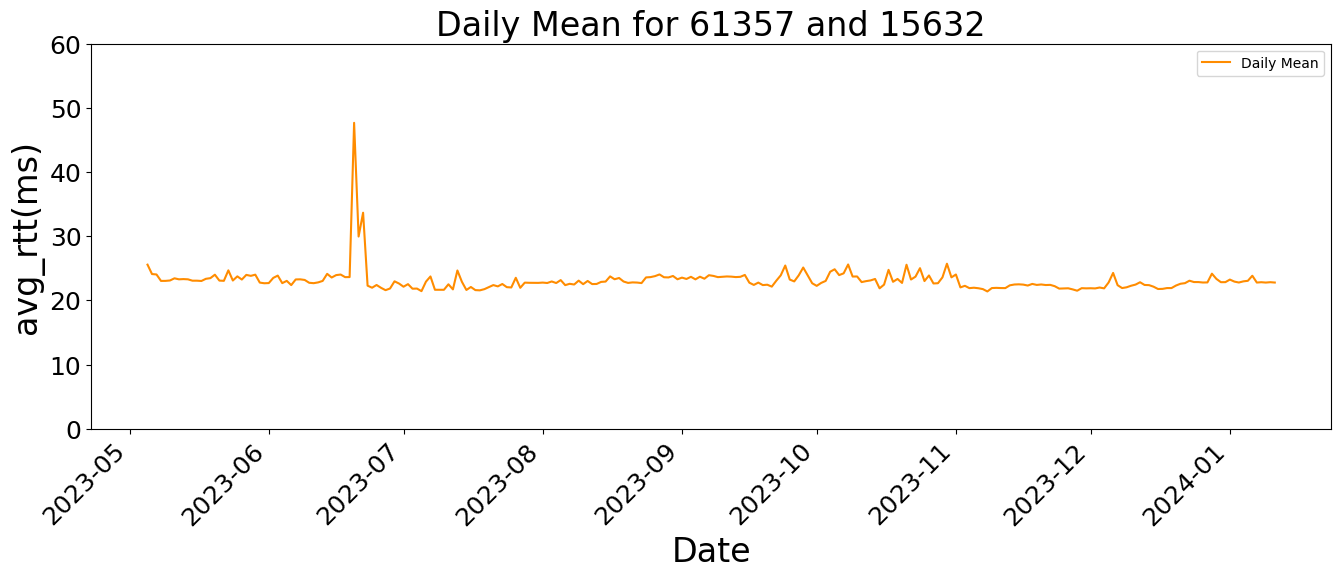

In [36]:
plot_mean(plot_df, sources[17], str(destinations[17]))

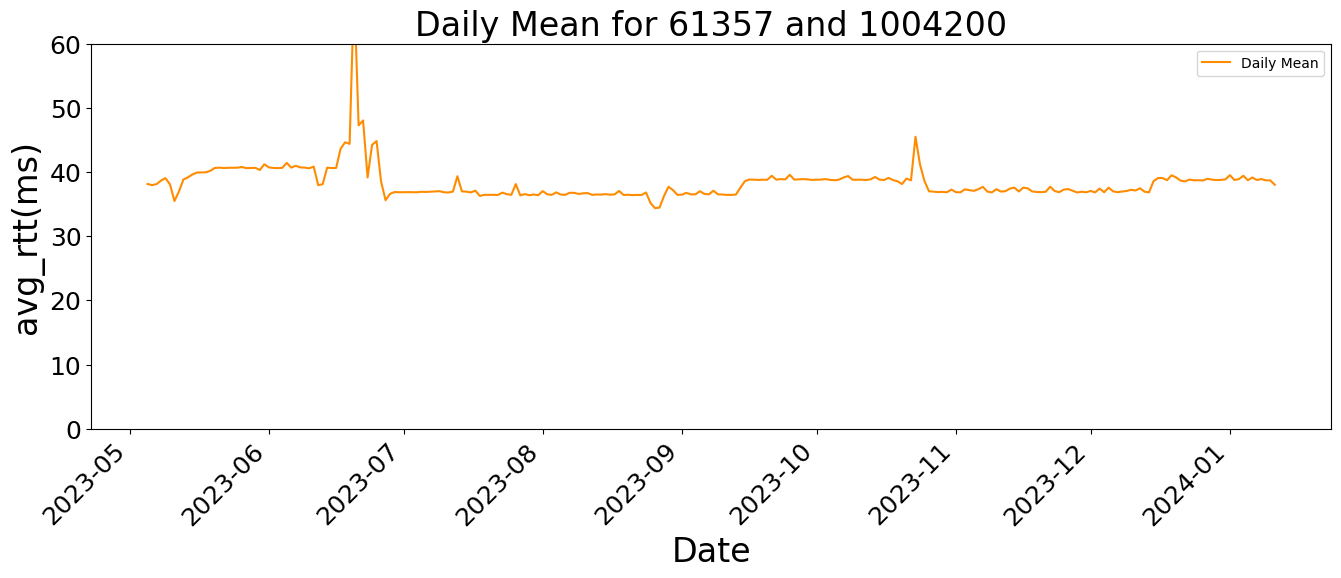

In [37]:
plot_mean(plot_df, sources[18], str(destinations[18]))

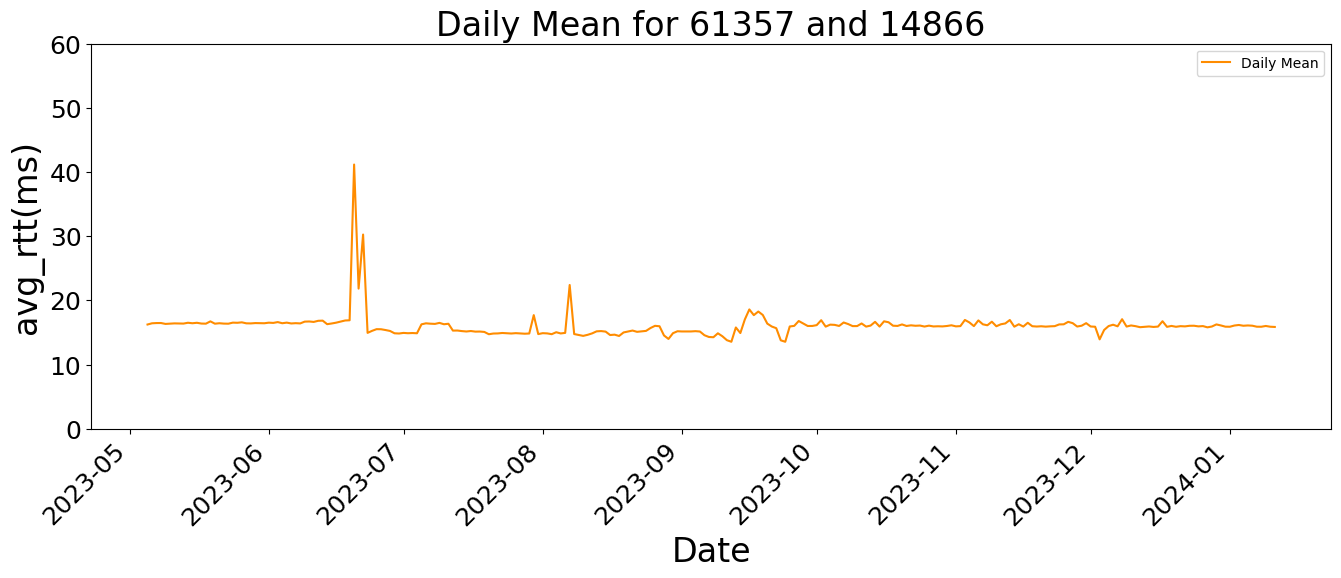

In [38]:
plot_mean(plot_df, sources[19], str(destinations[19]))

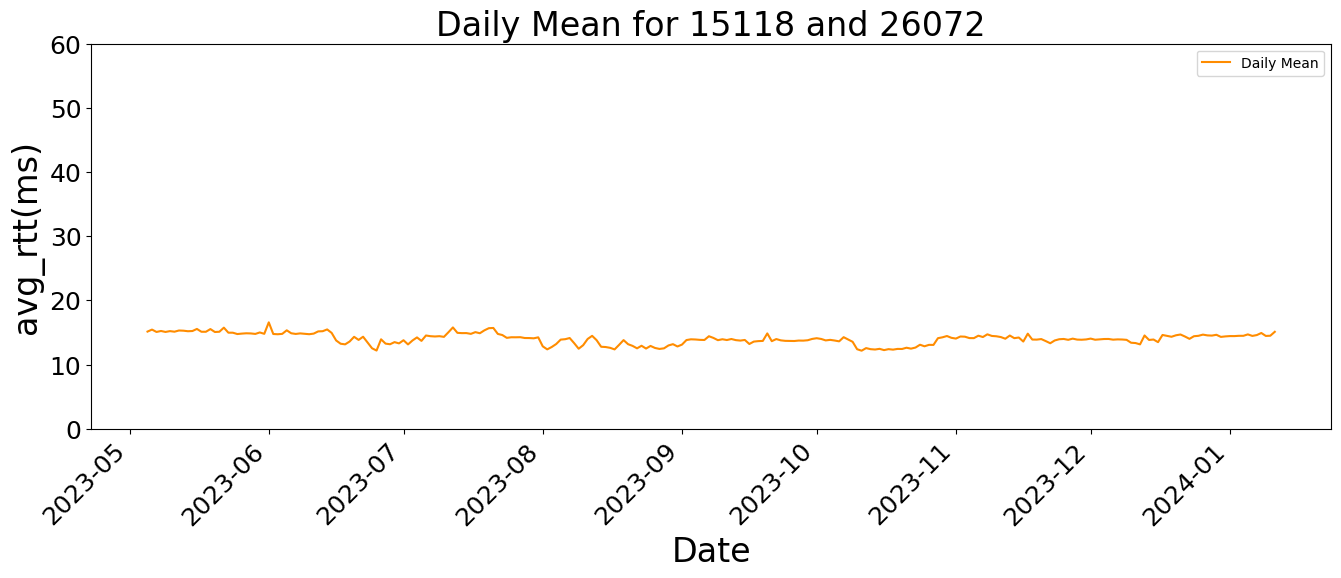

In [39]:
plot_mean(plot_df, sources[20], str(destinations[20]))

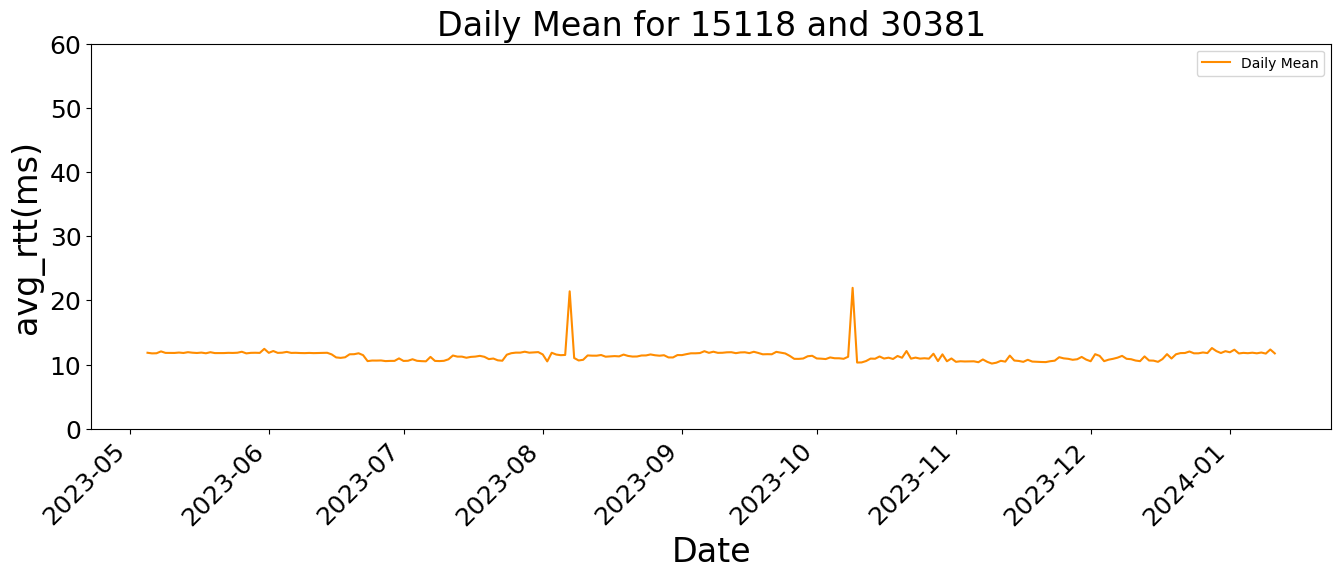

In [40]:
plot_mean(plot_df, sources[21], str(destinations[21]))

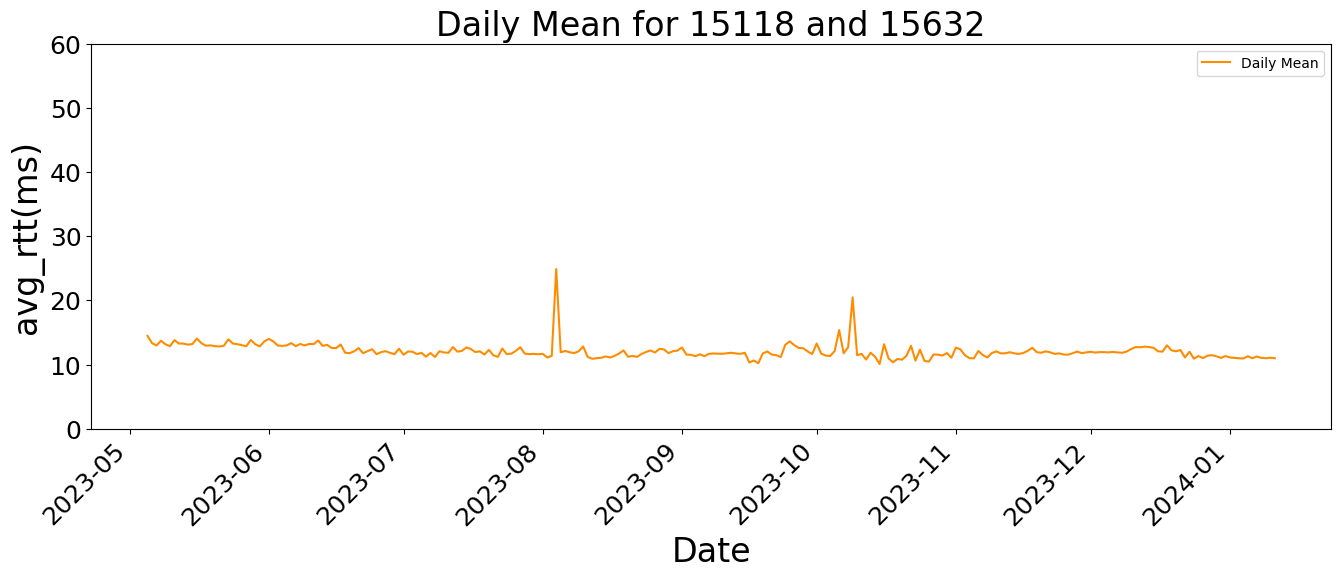

In [41]:
plot_mean(plot_df, sources[22], str(destinations[22]))

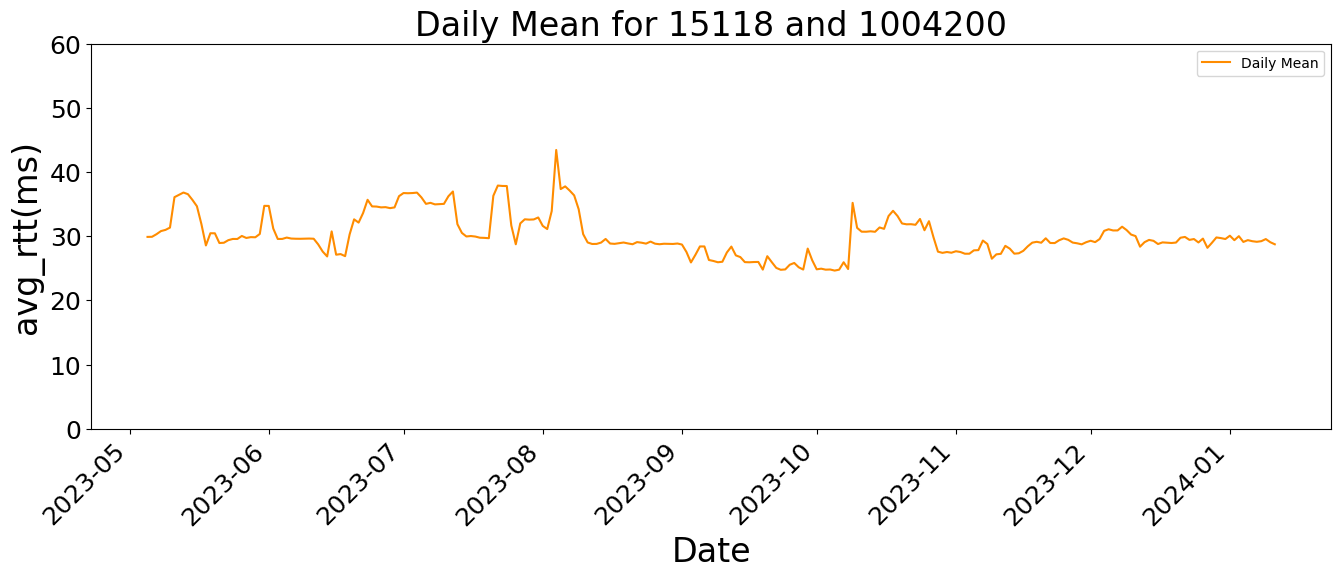

In [42]:
plot_mean(plot_df, sources[23], str(destinations[23]))

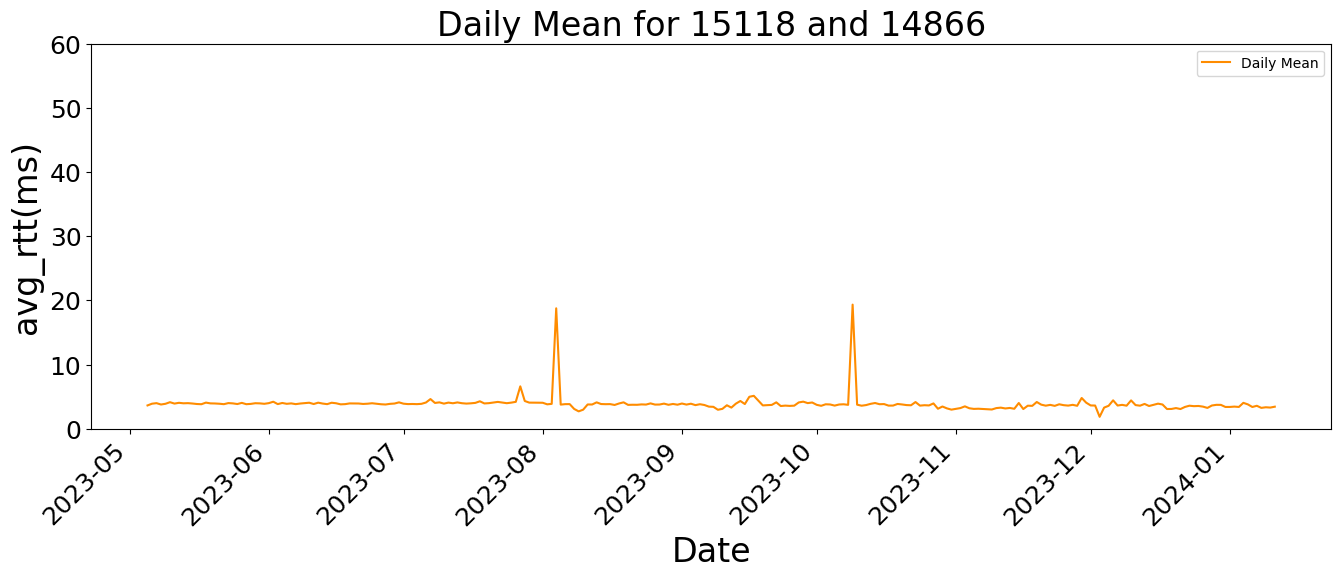

In [43]:
plot_mean(plot_df, sources[24], str(destinations[24]))